# Occupancy and Transaction Size Distributions

This notebook derives and computes the occupancy distribution $P(m)$ and transaction size distribution $P(w)$ for random walkers on activity-driven temporal networks, as described in:

> Mattsson, Cellerini, Ojer & Starnini, "Modeling financial transactions via random walks on temporal networks"

**Structure:**
- **Part 0:** Derivation of the Negative Binomial per-node marginal
- **Part 1:** $P(m)$ and $P(w)$ with global overdispersion (co-jumping correlations)
- **Part 2:** $P(m)$ and $P(w)$ with local overdispersion (Beta-Binomial transactions)

**Notation:**
- We use the NB$(r, p)$ parametrization where $r$ is the shape and $p = r/(r+\lambda)$, matching scipy.stats.nbinom
- Mean = $\lambda$, Variance = $\lambda + \lambda^2/r$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom, poisson
from scipy.special import gammaln
import pickle
import os

# Import our integration module (aligned with SM notation)
from distributions import (
    compute_params, print_params,
    compute_s_mean, compute_s_inv_mean,
    compute_r_global, compute_r_effective,
    compute_Pm, compute_Pw,
    compute_Pm_xi_sweep, compute_Pw_xi_sweep
)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 12

# Create figures directory
os.makedirs('figs', exist_ok=True)

---
# Part 0: Derivation of the Negative Binomial Per-Node Marginal

We derive the Negative Binomial distribution as the per-node marginal in the thermodynamic limit. This follows SM Section 1.2.2.

## Step 1: Independent Walkers — Binomial to Poisson

Consider $M$ independent random walkers on $N$ nodes. Each walker is at node $i$ with probability $\pi_i$ (the stationary probability). For independent walkers, the number of walkers at node $i$ follows a **Binomial** distribution:

$$m_i \sim \text{Binomial}(M, \pi_i)$$

**Thermodynamic limit:** Take $M \to \infty$ and $N \to \infty$ with $\langle m \rangle = M/N$ fixed. For each node, $\pi_i \to 0$ while $M \pi_i = \lambda_i$ remains fixed. In this limit:

$$\text{Binomial}(M, \pi_i) \to \text{Poisson}(\lambda_i)$$

This is the standard result for independent walkers.

## Step 2: Correlated Walkers — Beta-Binomial

On our temporal network, walkers don't move independently. They accumulate on a node until it activates, at which point each walker can jump with probability $s$. Walkers that both decide to jump end up at the same destination, introducing **correlations** in their co-location.

We model this pairwise correlation by replacing the Binomial with a **Beta-Binomial**. Following SM Eq. 7, the parametrization recovering the required mean $\lambda_s = M\pi_s$ is:

$$p(m \mid s) = \text{BetaBin}\left(M,\, \frac{r}{1 - \lambda_s/M},\, \frac{Mr}{\lambda_s}\right)$$

where $r$ is a free parameter accounting for correlations induced by co-jumping.

This introduces an **intra-class correlation (ICC)** — the pairwise correlation between any two walkers' presence at the same node. From SM Eq. 15, the ICC is approximately:

$$\text{ICC} \approx \frac{1}{N \langle s \rangle_h \cdot s \cdot r}$$

When ICC $= 0$ (i.e., $r \to \infty$), we recover the Binomial. When ICC $> 0$, walkers are positively correlated in their co-locations.

## Step 3: Thermodynamic Limit — Beta-Binomial to Negative Binomial

### The distributional limit

Note that $\lim_{M \to \infty} \frac{r}{1 - \lambda_s/M} = r$. The standard distributional limit (SM Eq. 8; Johnson, Kotz & Kemp, *Univariate Discrete Distributions*) gives:

$$\lim_{M\to\infty} \text{BetaBin}\left(M,\, r,\, \frac{Mr}{\lambda}\right) = \text{NB}(r, p)$$

where $p = r/(r + \lambda)$, so the NB has mean $\lambda$ and variance $\lambda + \lambda^2/r$.

### Constant ICC across heterogeneous nodes

Different nodes have different spending rates $s$ and hence different mean occupancies $\lambda_s = K_0/s$. While the propensity to co-jump depends on $s$, the resulting co-location could be anywhere (mean-field), so the **ICC should be constant** across all nodes.

From the ICC formula, requiring constant ICC across $s$ gives $r_s \cdot s = \text{const}$, i.e., $r_s \propto 1/s$.

## Step 4: Setting the Scale — The Patriarca Formula

What remains is to specify the constant of proportionality in $r \propto 1/s$. We take our cue from the wealth-exchange literature (Patriarca et al., *Physica A* 2010), which derives a formula for a continuous analogue in the homogeneous case.

Following SM Eq. 16, we set:

$$\boxed{r(s) = \frac{1 - \langle s \rangle_h}{s}}$$

**Physical interpretation:** In the homogeneous case $s_i = \langle s \rangle$ for all $i$, this gives $r = (1-s)/s$, the ratio of stay-probability to jump-probability. Larger $r$ means fewer walkers co-jump and less correlation.

### Final Result

The per-node occupancy distribution in the thermodynamic limit is:

$$m_s \sim \text{NB}(r_s, p_s)$$

with:
- Mean: $\lambda_s = K_0 / s$ where $K_0 = \langle m \rangle / \langle s^{-1} \rangle_h$
- Shape: $r_s = (1 - \langle s \rangle_h) / s$
- Probability: $p_s = r_s / (r_s + \lambda_s)$

**Limiting cases:**
- $\langle s \rangle \to 0$: $r \to \infty$, recovering Poisson (no correlation)
- Homogeneous ($s = \langle s \rangle$ for all nodes): $r = (1-s)/s$, the Patriarca formula

## Per-Node Marginals: Visualization

Let's visualize how the per-node marginal NB$(r_s, p_s)$ varies with spending rate $s$.

In [2]:
# Standard parameters
N = 10**4
M = 10**7
sigma = 0  # Uniform h(s)

def plot_per_node_marginals(s_max, s_values, ax, title_suffix=""):
    """
    Plot NB(m; r_s, p_s) for different spending rates s.
    """
    s_min = s_max / N
    
    # Compute system parameters
    s_mean = compute_s_mean(sigma, s_min, s_max)
    s_inv_mean = compute_s_inv_mean(sigma, s_min, s_max)
    mean_m = M / N
    K0 = mean_m / s_inv_mean
    
    # m range for plotting
    m_values = np.arange(1, 5000)
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(s_values)))
    
    for s, color in zip(s_values, colors):
        # Parameters for this node type
        lambda_s = K0 / s
        r_s = compute_r_global(s, s_mean)
        p_s = r_s / (r_s + lambda_s)  # NB(r, p) parametrization
        
        # NB PMF using scipy (matches our parametrization)
        P_m = nbinom.pmf(m_values, r_s, p_s)
        
        # Plot
        mask = P_m > 1e-8
        label = f's = {s:.3f}, r = {r_s:.2f}, λ = {lambda_s:.1f}'
        ax.loglog(m_values[mask], P_m[mask], '-', color=color, lw=2, label=label)
    
    ax.set_xlabel('m', fontsize=12)
    ax.set_ylabel('P(m | s)', fontsize=12)
    ax.set_title(f'Per-node marginal NB(r_s, p_s){title_suffix}', fontsize=12)
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(1, 5000)
    ax.set_ylim(1e-6, 1e-1)

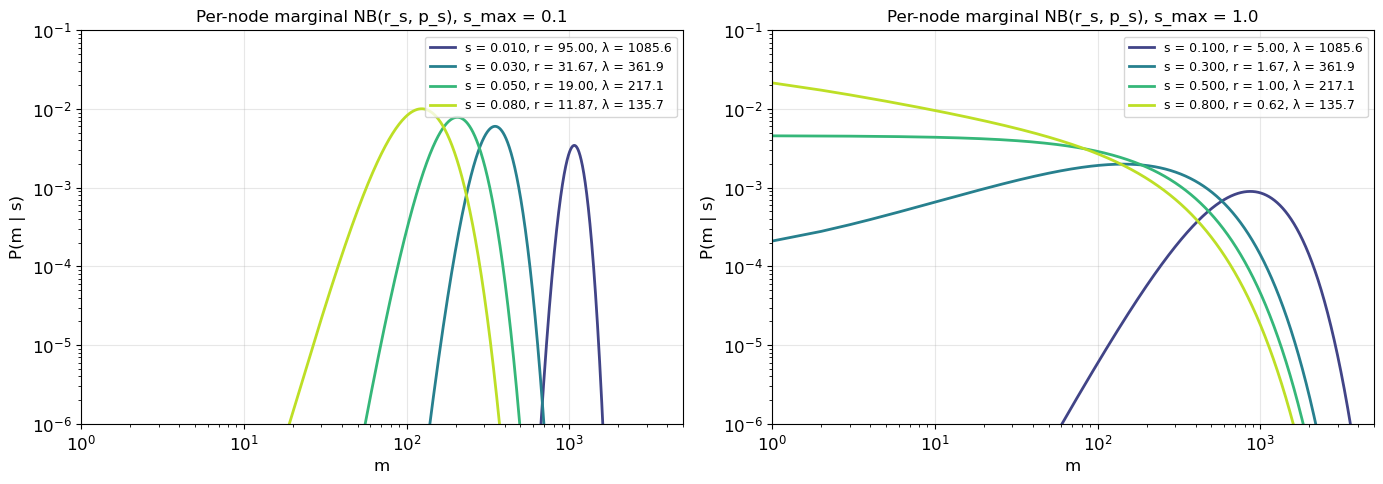

In [3]:
# Plot for different s_max values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Low s_max: nearly Poisson
plot_per_node_marginals(0.1, [0.01, 0.03, 0.05, 0.08], axes[0], 
                        ", s_max = 0.1")

# High s_max: significant overdispersion
plot_per_node_marginals(1.0, [0.1, 0.3, 0.5, 0.8], axes[1],
                        ", s_max = 1.0")

plt.tight_layout()
plt.savefig('figs/per_node_marginals.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Part 1: Aggregate Distributions (Global Overdispersion)

Now we compute the **aggregate** distributions $P(m)$ and $P(w)$ by integrating over the spending rate distribution $h(s)$.

"Global overdispersion" refers to the correlation from co-jumping — walkers arriving together at a destination have correlated presence there. This is captured by the $r(s)$ parameter derived above.

## Summary: Key Formulas (Global Overdispersion Only)

| Distribution | Negative Binomial | Poisson |
|:-------------|:------------------|:--------|
| **Occupancy $P(m)$** | $\displaystyle\int_{s_{\min}}^{s_{\max}} \text{NB}\!\left(m;\, r_s,\, p_s\right) h(s)\, ds$ | $\displaystyle\int_{s_{\min}}^{s_{\max}} \text{Pois}\!\left(m;\, \lambda_s\right) h(s)\, ds$ |
| **Transaction $P(w)$** | $\displaystyle\int_{s_{\min}}^{s_{\max}} \text{NB}\!\left(w;\, r_s,\, p_w\right) h(s)\, ds$ | $\text{Pois}(w;\, K_0)$ |

**Parameters:**
- $K_0 = \langle m \rangle / \langle s^{-1} \rangle_h$ — scale parameter
- $\lambda_s = K_0 / s$ — mean occupancy for node type $s$
- $r_s = (1 - \langle s \rangle_h) / s$ — shape parameter (global overdispersion)
- $p_s = r_s / (r_s + \lambda_s)$ — NB probability parameter for $P(m)$
- $p_w = r_s / (r_s + K_0)$ — NB probability parameter for $P(w)$ (mean = $K_0$)

**Key insight for $P(w)$:** After Binomial thinning, the Poisson mean becomes $s \cdot \lambda_s = K_0$, so $s$ cancels and **no integral is needed**. For NB, the shape $r_s$ still varies with $s$, so the integral remains.

**Universal tail behavior:** Both models give power-law tails (SM Eq. 22):
$$P(m) \sim m^{-(\sigma + 2)}$$
where $\sigma$ is the exponent in $h(s) \propto s^\sigma$.

In [4]:
# Standard parameters for all following computations
N = 10**4      # Number of nodes
M = 10**7      # Number of walkers  
s_max = 0.1    # Maximum spending rate
s_min = s_max / N  # Minimum spending rate
sigma = 0      # Uniform h(s)

# Compute derived parameters
params = compute_params(sigma, s_min, s_max, N, M)
print_params(params)

Model parameters:
  σ = 0.0 (spending rate distribution h(s) ∝ s^σ)
  s_min = 1.00e-05, s_max = 0.1
  N = 1.00e+04 nodes, M = 1.00e+07 walkers
  ⟨m⟩ = M/N = 1000.00
  ⟨s⟩_h = 0.050005
  ⟨s⁻¹⟩_h = 92.112615
  K₀ = ⟨m⟩/⟨s⁻¹⟩_h = 10.8563
  Crossover m* ≈ K₀/s_max = 108.6
  Expected tail: P(m) ~ m^-2.0 for m >> m*


## $P(m)$: Occupancy Distribution

The occupancy distribution integrates the per-node NB (or Poisson) over all node types weighted by $h(s)$.

In [5]:
# Compute P(m) for a range of values
m_values = np.unique(np.concatenate([
    np.arange(10, 100, 5),
    np.arange(100, 1000, 20),
    np.arange(1000, 5001, 100)
]))

print(f"Computing P(m) for {len(m_values)} values from {m_values[0]} to {m_values[-1]}...")
results_Pm = compute_Pm(m_values, params, xi=np.inf, verbose=True)

Computing P(m) for 104 values from 10 to 5000...
Model parameters:
  σ = 0.0 (spending rate distribution h(s) ∝ s^σ)
  s_min = 1.00e-05, s_max = 0.1
  N = 1.00e+04 nodes, M = 1.00e+07 walkers
  ⟨m⟩ = M/N = 1000.00
  ⟨s⟩_h = 0.050005
  ⟨s⁻¹⟩_h = 92.112615
  K₀ = ⟨m⟩/⟨s⁻¹⟩_h = 10.8563
  Crossover m* ≈ K₀/s_max = 108.6
  Expected tail: P(m) ~ m^-2.0 for m >> m*
  ξ = ∞ (local overdispersion from Beta-Binomial)

Computing P(m) for 104 values...
    9.6% complete (m=55)
   19.2% complete (m=120)
   28.8% complete (m=320)
   38.5% complete (m=520)
   48.1% complete (m=720)
   57.7% complete (m=920)
   67.3% complete (m=1600)
   76.9% complete (m=2600)
   86.5% complete (m=3600)
   96.2% complete (m=4600)
  Done!


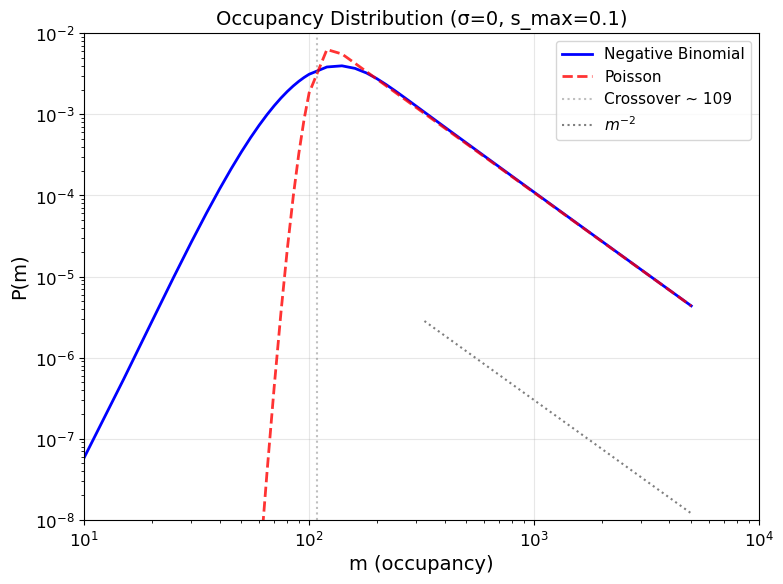


Crossover m ~ K₀/s_max = 108.6
Below crossover: NB shows higher probability (overdispersion effect)
Above crossover: Both converge to m^{-2} power law


In [6]:
# Plot P(m): NB vs Poisson
fig, ax = plt.subplots(figsize=(8, 6))

m = results_Pm['m'].astype(float)
P_nb = results_Pm['P_nb']
P_pois = results_Pm['P_poisson']
crossover = params['crossover_m']

mask_nb = P_nb > 1e-12
mask_p = P_pois > 1e-12

ax.loglog(m[mask_nb], P_nb[mask_nb], 'b-', lw=2, label='Negative Binomial')
ax.loglog(m[mask_p], P_pois[mask_p], 'r--', lw=2, alpha=0.8, label='Poisson')

# Mark crossover
ax.axvline(crossover, color='gray', ls=':', alpha=0.5, label=f'Crossover ~ {crossover:.0f}')

# Power law reference
m_ref = np.logspace(np.log10(crossover * 3), np.log10(m[-1]), 30)
P_ref = 0.3 * m_ref**(-2.0)  # σ=0 → ν=2
ax.loglog(m_ref, P_ref, 'k:', alpha=0.5, label=r'$m^{-2}$')

ax.set_xlabel('m (occupancy)', fontsize=14)
ax.set_ylabel('P(m)', fontsize=14)
ax.set_title(f'Occupancy Distribution (σ={sigma}, s_max={s_max})', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(10, 1e4)
ax.set_ylim(1e-8, 1e-2)

plt.tight_layout()
plt.savefig('figs/Pm_basic.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCrossover m ~ K₀/s_max = {crossover:.1f}")
print("Below crossover: NB shows higher probability (overdispersion effect)")
print("Above crossover: Both converge to m^{-2} power law")

## $P(w)$: Transaction Size Distribution

The transaction size distribution is obtained by Binomial thinning of the occupancy distribution.

In [7]:
# Compute P(w) for a range of values
w_values = np.arange(1, 51)

print(f"Computing P(w) for {len(w_values)} values...")
results_Pw = compute_Pw(w_values, params, xi=np.inf, verbose=True)

Computing P(w) for 50 values...
Model parameters:
  σ = 0.0 (spending rate distribution h(s) ∝ s^σ)
  s_min = 1.00e-05, s_max = 0.1
  N = 1.00e+04 nodes, M = 1.00e+07 walkers
  ⟨m⟩ = M/N = 1000.00
  ⟨s⟩_h = 0.050005
  ⟨s⁻¹⟩_h = 92.112615
  K₀ = ⟨m⟩/⟨s⁻¹⟩_h = 10.8563
  Crossover m* ≈ K₀/s_max = 108.6
  Expected tail: P(m) ~ m^-2.0 for m >> m*
  ξ = ∞ (local overdispersion from Beta-Binomial)

Computing P(w) for 50 values...
  w=1: P_nb=1.5025e-03
  w=2: P_nb=5.0107e-03
  w=3: P_nb=1.2094e-02
  w=4: P_nb=2.3518e-02
  w=5: P_nb=3.8943e-02
  w=6: P_nb=5.6732e-02
  w=7: P_nb=7.4276e-02
  w=8: P_nb=8.8712e-02
  w=9: P_nb=9.7751e-02
  w=10: P_nb=1.0027e-01
  w=11: P_nb=9.6475e-02
  w=12: P_nb=8.7645e-02
  w=13: P_nb=7.5636e-02
  w=14: P_nb=6.2348e-02
  w=15: P_nb=4.9351e-02
  w=16: P_nb=3.7695e-02
  w=17: P_nb=2.7913e-02
  w=18: P_nb=2.0127e-02
  w=19: P_nb=1.4189e-02
  w=20: P_nb=9.8148e-03
  w=21: P_nb=6.6831e-03
  w=22: P_nb=4.4918e-03
  w=23: P_nb=2.9868e-03
  w=24: P_nb=1.9684e-03
  w=25

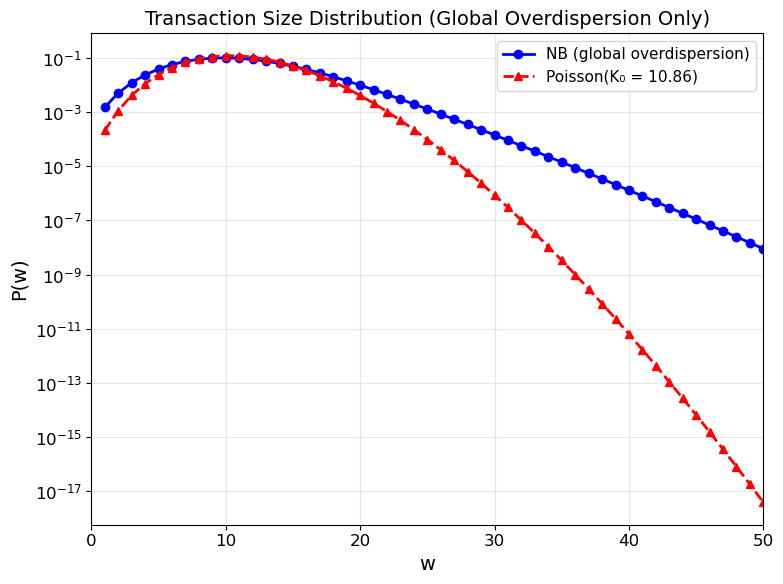


Key insight: For Poisson, P(w) = Poisson(K₀=10.86)
The s cancels because s · (K₀/s) = K₀!
For NB, the shape parameter r_s = (1-⟨s⟩)/s still varies, so integral needed.


In [8]:
# Plot P(w): NB vs Poisson
fig, ax = plt.subplots(figsize=(8, 6))

w = results_Pw['w']
P_nb = results_Pw['P_nb']
P_pois = results_Pw['P_poisson']

ax.semilogy(w, P_nb, 'bo-', lw=2, ms=6, label='NB (global overdispersion)')
ax.semilogy(w, P_pois, 'r^--', lw=2, ms=6, label=f'Poisson(K₀ = {params["K0"]:.2f})')

ax.set_xlabel('w', fontsize=14)
ax.set_ylabel('P(w)', fontsize=14)
ax.set_title('Transaction Size Distribution (Global Overdispersion Only)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 50)

plt.tight_layout()
plt.savefig('figs/Pw_basic.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nKey insight: For Poisson, P(w) = Poisson(K₀={params['K0']:.2f})")
print("The s cancels because s · (K₀/s) = K₀!")
print("For NB, the shape parameter r_s = (1-⟨s⟩)/s still varies, so integral needed.")

## Effect of $\sigma$: Spending Rate Distribution Shape

The tail exponent $P(m) \sim m^{-(\sigma + 2)}$ depends on the exponent $\sigma$ in $h(s) \propto s^\sigma$.

In [9]:
# Compute P(m) for different sigma values
sigma_values = [-4, -2, 0, 2]
results_sigma = {}

for sigma_val in sigma_values:
    print(f"\nComputing σ = {sigma_val}...")
    params_sigma = compute_params(sigma_val, s_min, s_max, N, M)
    results_sigma[sigma_val] = compute_Pm(m_values, params_sigma, 
                                          xi=np.inf, verbose=False)
    results_sigma[sigma_val]['params'] = params_sigma


Computing σ = -4...

Computing σ = -2...

Computing σ = 0...

Computing σ = 2...


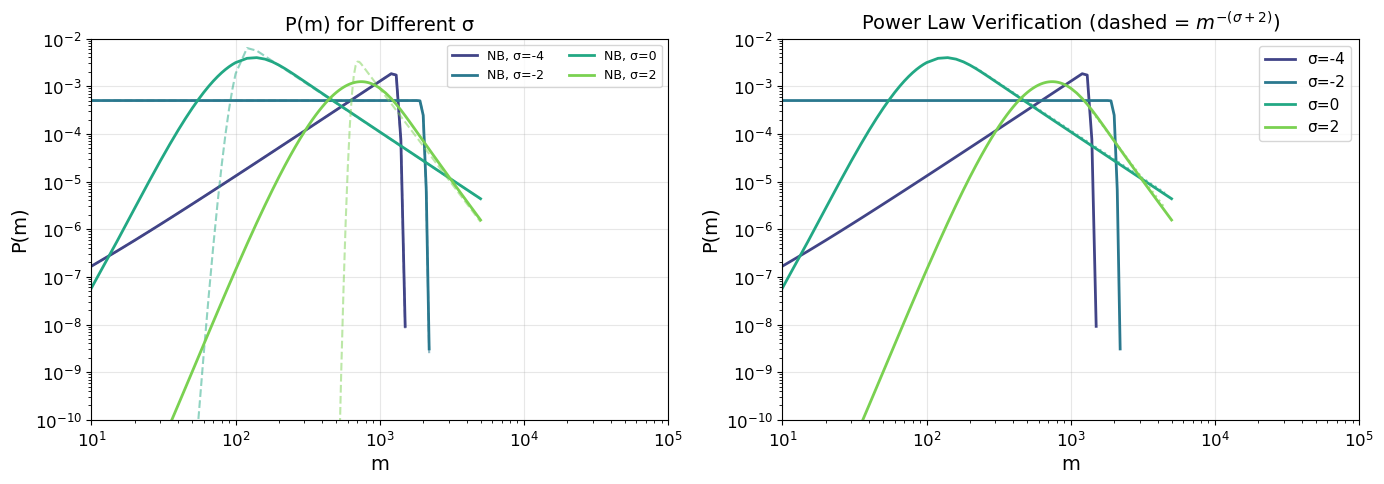

In [10]:
# Plot P(m) for different sigma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors_sigma = plt.cm.viridis(np.linspace(0.2, 0.8, len(sigma_values)))

for sigma_val, color in zip(sigma_values, colors_sigma):
    data = results_sigma[sigma_val]
    m = data['m'].astype(float)
    P_nb = data['P_nb']
    P_pois = data['P_poisson']
    crossover = data['params']['crossover_m']
    
    mask_nb = P_nb > 1e-12
    mask_p = P_pois > 1e-12
    
    # Left panel: NB and Poisson
    ax1.loglog(m[mask_nb], P_nb[mask_nb], '-', color=color, lw=2, label=f'NB, σ={sigma_val}')
    ax1.loglog(m[mask_p], P_pois[mask_p], '--', color=color, lw=1.5, alpha=0.5)
    
    # Right panel: with power law reference
    ax2.loglog(m[mask_nb], P_nb[mask_nb], '-', color=color, lw=2, label=f'σ={sigma_val}')
    
    # Power law reference
    nu = sigma_val + 2
    if nu > 0:
        m_ref = np.logspace(np.log10(crossover * 2), np.log10(m[mask_nb][-1] * 0.9), 30)
        # Amplitude from data
        idx = np.argmin(np.abs(m - crossover * 3))
        if P_nb[idx] > 0:
            A = P_nb[idx] * (crossover * 3)**nu
            ax2.loglog(m_ref, A * m_ref**(-nu), ':', color=color, alpha=0.6)

ax1.set_xlabel('m', fontsize=14)
ax1.set_ylabel('P(m)', fontsize=14)
ax1.set_title('P(m) for Different σ', fontsize=14)
ax1.legend(loc='upper right', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(10, 1e5)
ax1.set_ylim(1e-10, 1e-2)

ax2.set_xlabel('m', fontsize=14)
ax2.set_ylabel('P(m)', fontsize=14)
ax2.set_title(r'Power Law Verification (dashed = $m^{-(\sigma+2)}$)', fontsize=14)
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(10, 1e5)
ax2.set_ylim(1e-10, 1e-2)

plt.tight_layout()
plt.savefig('figs/Pm_sigma_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Part 2: Local Overdispersion (Beta-Binomial Transactions)

In addition to *global* overdispersion from co-jumping (the $r$ parameter), we can introduce *local* overdispersion via the precision parameter $\xi$.

**Local overdispersion** refers to variance in individual spending behavior — the same agent may spend more or less than their average propensity $s_i$ on different transactions. This is modeled by Beta-Binomial thinning instead of Binomial.

## Combining Two Sources of Overdispersion

For the NB distribution, variance = $\lambda + \lambda^2/r$, where $\lambda^2/r$ is the "excess variance" from overdispersion.

When two independent sources contribute:
- Global (co-jumping): contributes $\lambda^2/r_{\text{global}}$ where $r_{\text{global}} = (1 - \langle s \rangle)/s$
- Local (Beta-Binomial): contributes $\lambda^2/\xi$

Total excess variance adds: $\frac{\lambda^2}{r_{\text{eff}}} = \frac{\lambda^2}{r_{\text{global}}} + \frac{\lambda^2}{\xi}$

This gives the **harmonic combination rule** (SM Eq. 20):

$$\boxed{\frac{1}{r_{\text{eff}}(s)} = \frac{1}{r_{\text{global}}(s)} + \frac{1}{\xi} = \frac{s}{1 - \langle s \rangle} + \frac{1}{\xi}}$$

**Limits:**
- $\xi \to \infty$: Binomial transactions, only global overdispersion
- $\xi \to 0$: Maximum local correlation

## Summary: Key Formulas with Local Overdispersion

| Distribution | Formula |
|:-------------|:--------|
| **Occupancy $P(m)$** | $\displaystyle\int_{s_{\min}}^{s_{\max}} \text{NB}\!\left(m;\, r_{\text{eff}}(s),\, p_s\right) h(s)\, ds$ |
| **Transaction $P(w)$** | $\displaystyle\int_s \int_\kappa \int_\rho \text{Pois}(w; \rho\kappa)\, \text{Gamma}(\kappa; r_s, \lambda_s)\, \text{Beta}(\rho; \xi s, \xi(1-s))\, d\rho\, d\kappa\, h(s)\, ds$ |

where $r_{\text{eff}}(s) = \left(\frac{s}{1-\langle s\rangle} + \frac{1}{\xi}\right)^{-1}$

For $P(w)$, the Beta-Binomial thinning requires the more complex Poisson-Gamma-Beta compound integral (SM Eq. 43).

In [11]:
# Compute P(m) for different ξ values
xi_values_Pm = [1, 10, 100, 1000, np.inf]

m_values_xi = np.unique(np.concatenate([
    np.arange(10, 100, 2),
    np.arange(100, 1000, 10),
    np.arange(1000, 50001, 500)
]))

print(f"Computing P(m) for {len(m_values_xi)} m values and {len(xi_values_Pm)} ξ values...")
results_Pm_xi = compute_Pm_xi_sweep(m_values_xi, params, xi_values_Pm, verbose=True)

Computing P(m) for 234 m values and 5 ξ values...
Model parameters:
  σ = 0.0 (spending rate distribution h(s) ∝ s^σ)
  s_min = 1.00e-05, s_max = 0.1
  N = 1.00e+04 nodes, M = 1.00e+07 walkers
  ⟨m⟩ = M/N = 1000.00
  ⟨s⟩_h = 0.050005
  ⟨s⁻¹⟩_h = 92.112615
  K₀ = ⟨m⟩/⟨s⁻¹⟩_h = 10.8563
  Crossover m* ≈ K₀/s_max = 108.6
  Expected tail: P(m) ~ m^-2.0 for m >> m*

Computing P(m) for 234 values, ξ ∈ {1, 10, 100, 1000, ∞}
    9.8% complete (m=54)
   19.7% complete (m=100)
   29.5% complete (m=330)
   39.3% complete (m=560)
   49.1% complete (m=790)
   59.0% complete (m=2000)
   68.8% complete (m=13500)
   78.6% complete (m=25000)
   88.5% complete (m=36500)
   98.3% complete (m=48000)
  Done!


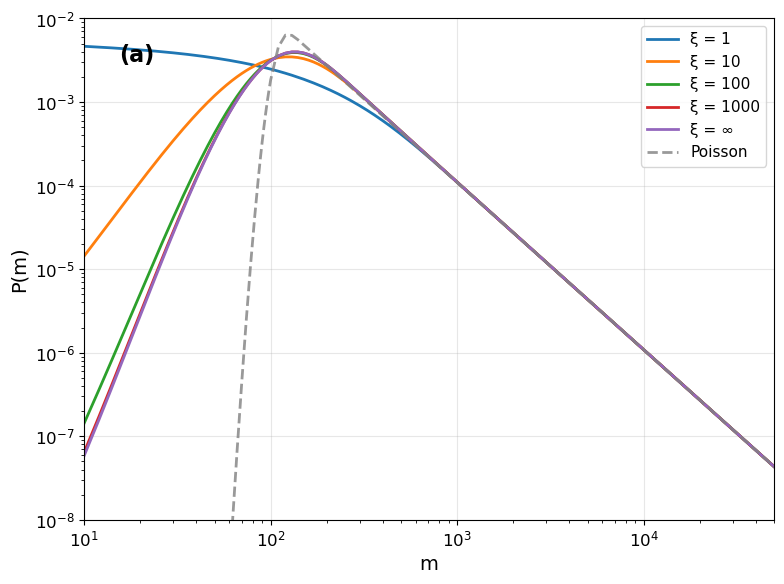


ξ controls local overdispersion from Beta-Binomial transactions:
  - ξ = ∞: Binomial limit (global overdispersion only)
  - ξ = 1: Strong local correlation
  - Lower ξ → more overdispersion → heavier tails at low m


In [12]:
# Plot P(m) for different ξ - Figure 1(a) style
fig, ax = plt.subplots(figsize=(8, 6))

colors_xi_plot = {
    1: 'tab:blue',
    10: 'tab:orange',
    100: 'tab:green',
    1000: 'tab:red',
    np.inf: 'tab:purple'
}

m = results_Pm_xi['m'].astype(float)

for xi in xi_values_Pm:
    xi_str = '∞' if np.isinf(xi) else str(int(xi))
    P_m = results_Pm_xi['P_m'][xi]
    
    mask = P_m > 1e-10
    ax.loglog(m[mask], P_m[mask], '-', color=colors_xi_plot[xi],
              lw=2, label=f'ξ = {xi_str}')

# Poisson reference
P_pois = results_Pm_xi['P_poisson']
mask_p = P_pois > 1e-10
ax.loglog(m[mask_p], P_pois[mask_p], '--', color='gray',
          lw=2, alpha=0.8, label='Poisson')

ax.set_xlabel('m', fontsize=14)
ax.set_ylabel('P(m)', fontsize=14)
ax.set_xlim(10, 5e4)
ax.set_ylim(1e-8, 1e-2)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.text(0.05, 0.95, '(a)', transform=ax.transAxes, fontsize=16,
        fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('figs/Pm_local_overdispersion.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nξ controls local overdispersion from Beta-Binomial transactions:")
print("  - ξ = ∞: Binomial limit (global overdispersion only)")
print("  - ξ = 1: Strong local correlation")
print("  - Lower ξ → more overdispersion → heavier tails at low m")

## $P(w)$ with Local Overdispersion

For finite $\xi$, the transaction size distribution requires the full Poisson-Gamma-Beta integral. This is computationally expensive but captures the heavy tail that emerges from local overdispersion.

In [13]:
# Compute P(w) for different ξ values
# This is slow for finite ξ due to 3D integration

w_values_xi = np.arange(1, 100)
xi_values_Pw = [1, 10, 100, 1000, np.inf]

print("Computing P(w) with local overdispersion...")
print("(This may take several minutes for finite ξ)\n")

results_Pw_xi = compute_Pw_xi_sweep(w_values_xi, params, xi_values_Pw, 
                                     verbose=True)

Computing P(w) with local overdispersion...
(This may take several minutes for finite ξ)

Model parameters:
  σ = 0.0 (spending rate distribution h(s) ∝ s^σ)
  s_min = 1.00e-05, s_max = 0.1
  N = 1.00e+04 nodes, M = 1.00e+07 walkers
  ⟨m⟩ = M/N = 1000.00
  ⟨s⟩_h = 0.050005
  ⟨s⁻¹⟩_h = 92.112615
  K₀ = ⟨m⟩/⟨s⁻¹⟩_h = 10.8563
  Crossover m* ≈ K₀/s_max = 108.6
  Expected tail: P(m) ~ m^-2.0 for m >> m*

Computing P(w) for 99 values, ξ ∈ {1, 10, 100, 1000, ∞}
  Finite ξ: Poisson-Gamma-Beta integration (n_κ=100, n_ρ=50, n_s=200)
  w = 1 (1/99)...
    ξ=1: P(w)=5.6881e-02
    ξ=10: P(w)=1.3077e-01
    ξ=100: P(w)=5.0481e-02
    ξ=1000: P(w)=6.3861e-03
  w = 2 (2/99)...
    ξ=1: P(w)=1.9631e-02
    ξ=10: P(w)=6.0712e-02
    ξ=100: P(w)=4.9144e-02
    ξ=1000: P(w)=1.4104e-02
  w = 3 (3/99)...
    ξ=1: P(w)=1.1397e-02
    ξ=10: P(w)=4.3484e-02
    ξ=100: P(w)=4.8933e-02
    ξ=1000: P(w)=2.4451e-02
  w = 4 (4/99)...
    ξ=1: P(w)=8.5890e-03
    ξ=10: P(w)=3.7716e-02
    ξ=100: P(w)=5.2175e-02
   

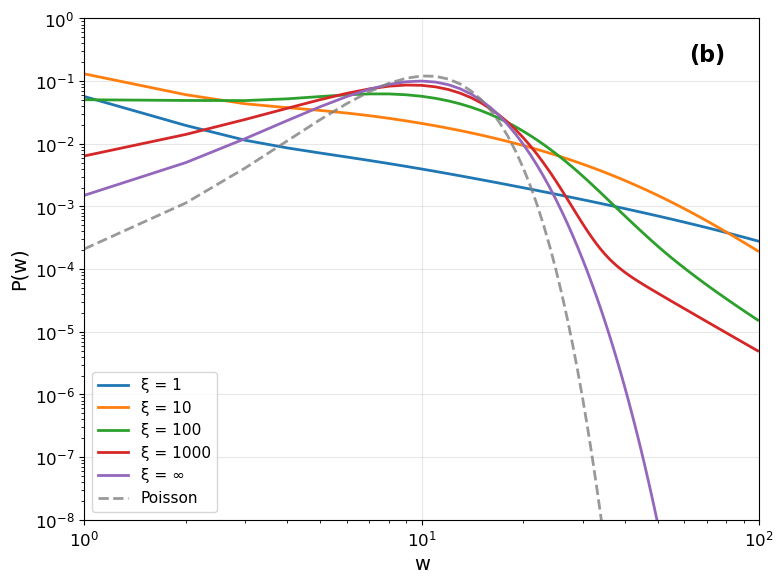

In [14]:
# Plot P(w) for different ξ - Figure 1(b) style
fig, ax = plt.subplots(figsize=(8, 6))

for xi in xi_values_Pw:
    xi_str = '∞' if np.isinf(xi) else str(int(xi))
    P_w = results_Pw_xi['P_w'][xi]
    w = results_Pw_xi['w']
    
    mask = P_w > 1e-12
    ax.loglog(w[mask], P_w[mask], '-', color=colors_xi_plot[xi],
              lw=2, label=f'ξ = {xi_str}')

# Poisson reference
P_pois_w = results_Pw_xi['P_poisson']
mask_p = P_pois_w > 1e-12
ax.loglog(w_values_xi[mask_p], P_pois_w[mask_p], '--', color='gray',
          lw=2, alpha=0.8, label='Poisson')

ax.set_xlabel('w', fontsize=14)
ax.set_ylabel('P(w)', fontsize=14)
ax.set_xlim(1, 1e2)
ax.set_ylim(1e-8, 1)
ax.legend(loc='lower left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.text(0.95, 0.95, '(b)', transform=ax.transAxes, fontsize=16,
        fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('figs/Pw_local_overdispersion.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Save Results

In [15]:
# Save key results
results_to_save = {
    'params': params,
    'Pm_basic': results_Pm,
    'Pw_basic': results_Pw,
    'Pm_sigma': results_sigma,
    'Pm_xi': results_Pm_xi,
    'Pw_xi': results_Pw_xi
}

with open('results.pkl', 'wb') as f:
    pickle.dump(results_to_save, f)

print("Results saved to results.pkl")

Results saved to results.pkl


---
## Summary

This notebook has demonstrated:

1. **Derivation** of the NB per-node marginal from Beta-Binomial co-location correlation in the thermodynamic limit

2. **Global overdispersion** from co-jumping:
   - Captured by $r(s) = (1 - \langle s \rangle)/s$
   - Produces power-law tails $P(m) \sim m^{-(\sigma+2)}$
   
3. **Local overdispersion** from Beta-Binomial transactions:
   - Captured by precision parameter $\xi$
   - Combined via $1/r_{\text{eff}} = 1/r + 1/\xi$
   - Produces heavy tails in $P(w)$ that Binomial thinning cannot

The numerical integration uses log-space arithmetic for stability, following SM Section 1.4.